# Absolute Momentum

Description

In [78]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

from utils import historic_cdi, historic_imab5, STAR_DATE, END_DATE

### Importando os dados

In [79]:
IBOV = yf.Ticker('^BVSP')

ibov_prices = IBOV.history(start=STAR_DATE, end=END_DATE)['Close']
ibov_prices.index = pd.to_datetime(ibov_prices.index).date

In [80]:
cdi = historic_cdi(start=STAR_DATE, end=END_DATE)
imab5 = historic_imab5(start=STAR_DATE, end=END_DATE)
ibov = (ibov_prices / ibov_prices.iloc[0])

In [81]:
absolute_prices = pd.concat([ibov, cdi, imab5], keys=['IBOV', 'CDI', 'IMA-B 5'], join='outer', axis=1)
absolute_prices = absolute_prices.dropna()


absolute_prices

,IBOV,CDI,IMA-B 5
2004-01-02,1.000000,1.000000,1.000000
2004-01-05,1.048429,1.000601,1.000576
2004-01-06,1.050390,1.001202,1.001922
2004-01-07,1.038984,1.001803,1.003517
2004-01-08,1.056672,1.002405,1.007081
...,...,...,...
2024-09-03,5.985877,8.218644,11.254458
2024-09-04,6.064201,8.221871,11.275119
2024-09-05,6.081622,8.225100,11.288138
2024-09-06,5.995634,8.228330,11.287673


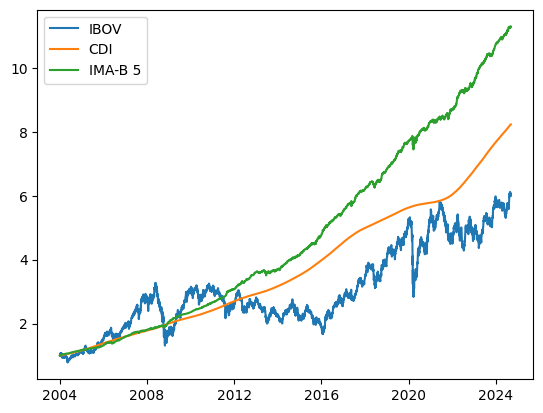

In [82]:

plt.plot(absolute_prices)
plt.legend(absolute_prices.columns)
plt.show()

In [83]:
ytd_returns = absolute_prices.pct_change(periods=252).dropna()
ytd_returns.index = pd.to_datetime(ytd_returns.index)

ytd_returns = ytd_returns.loc['2005-01-18':END_DATE]

ytd_returns

,IBOV,CDI,IMA-B 5
2005-01-18,0.029488,0.165227,0.162699
2005-01-19,0.057007,0.165284,0.161632
2005-01-20,0.019650,0.165361,0.161619
2005-01-21,0.018516,0.165437,0.161725
2005-01-24,0.021918,0.165514,0.160121
...,...,...,...
2024-09-03,0.143089,0.113408,0.079185
2024-09-04,0.175986,0.113300,0.083757
2024-09-05,0.157847,0.113191,0.084500
2024-09-06,0.142600,0.113082,0.084395


In [84]:
time_series = pd.to_datetime(ytd_returns.index).to_series()
first_trading_day = time_series.groupby(time_series.index.to_period('M')).apply(lambda x: x == x.min())

ytd_returns.loc[first_trading_day.values]

,IBOV,CDI,IMA-B 5
2005-01-18,0.029488,0.165227,0.162699
2005-02-01,-0.003178,0.166668,0.161056
2005-03-01,0.299620,0.168233,0.140095
2005-04-01,0.274952,0.170637,0.137230
2005-05-02,0.158554,0.173259,0.140051
...,...,...,...
2024-05-02,0.235118,0.124183,0.084812
2024-06-03,0.106034,0.121508,0.090099
2024-07-01,0.061222,0.118929,0.082131
2024-08-01,0.059973,0.115970,0.085338


In [85]:
conditions = [
    first_trading_day.values & (ytd_returns['IBOV'] > ytd_returns['CDI']),
    first_trading_day.values & (ytd_returns['IBOV'] <= ytd_returns['CDI']),
]

cases = ['IBOV', 'IMA-B 5']

ytd_returns['Investment'] = np.select(conditions, cases, default=None)
ytd_returns['Investment'] = ytd_returns['Investment'].ffill()

ytd_returns

,IBOV,CDI,IMA-B 5,Investment
2005-01-18,0.029488,0.165227,0.162699,IMA-B 5
2005-01-19,0.057007,0.165284,0.161632,IMA-B 5
2005-01-20,0.019650,0.165361,0.161619,IMA-B 5
2005-01-21,0.018516,0.165437,0.161725,IMA-B 5
2005-01-24,0.021918,0.165514,0.160121,IMA-B 5
...,...,...,...,...
2024-09-03,0.143089,0.113408,0.079185,IBOV
2024-09-04,0.175986,0.113300,0.083757,IBOV
2024-09-05,0.157847,0.113191,0.084500,IBOV
2024-09-06,0.142600,0.113082,0.084395,IBOV


In [86]:
ytd_returns['Investment'].value_counts(normalize=True).round(2)

Investment
IMA-B 5    0.51
IBOV       0.49
Name: proportion, dtype: float64

In [87]:
absolute_momentum = absolute_prices.pct_change().join(ytd_returns[['Investment']], how='right')

absolute_momentum

,IBOV,CDI,IMA-B 5,Investment
2005-01-18,-0.017377,0.000648,0.000679,IMA-B 5
2005-01-19,0.007555,0.000649,0.000685,IMA-B 5
2005-01-20,-0.027234,0.000665,0.000594,IMA-B 5
2005-01-21,0.008810,0.000665,0.000761,IMA-B 5
2005-01-24,0.015954,0.000665,0.000660,IMA-B 5
...,...,...,...,...
2024-09-03,-0.004653,0.000393,-0.000168,IBOV
2024-09-04,0.013085,0.000393,0.001836,IBOV
2024-09-05,0.002873,0.000393,0.001155,IBOV
2024-09-06,-0.014139,0.000393,-0.000041,IBOV


In [88]:
absolute_momentum['Absolute Momentum'] = absolute_momentum.apply(lambda row: row[row['Investment']], axis=1)
absolute_momentum = absolute_momentum.drop(columns=['Investment'])

absolute_momentum

,IBOV,CDI,IMA-B 5,Absolute Momentum
2005-01-18,-0.017377,0.000648,0.000679,0.000679
2005-01-19,0.007555,0.000649,0.000685,0.000685
2005-01-20,-0.027234,0.000665,0.000594,0.000594
2005-01-21,0.008810,0.000665,0.000761,0.000761
2005-01-24,0.015954,0.000665,0.000660,0.000660
...,...,...,...,...
2024-09-03,-0.004653,0.000393,-0.000168,-0.004653
2024-09-04,0.013085,0.000393,0.001836,0.013085
2024-09-05,0.002873,0.000393,0.001155,0.002873
2024-09-06,-0.014139,0.000393,-0.000041,-0.014139


In [89]:
absolute_momentum_eval = (1 + absolute_momentum).cumprod()
absolute_momentum_eval = (absolute_momentum_eval / absolute_momentum_eval.iloc[0]) - 1

absolute_momentum_eval

,IBOV,CDI,IMA-B 5,Absolute Momentum
2005-01-18,0.000000,0.000000,0.000000,0.000000
2005-01-19,0.007555,0.000649,0.000685,0.000685
2005-01-20,-0.019885,0.001314,0.001280,0.001280
2005-01-21,-0.011250,0.001980,0.002042,0.002042
2005-01-24,0.004525,0.002646,0.002704,0.002704
...,...,...,...,...
2024-09-03,4.577359,6.019473,8.507709,5.420633
2024-09-04,4.650338,6.022230,8.525164,5.504647
2024-09-05,4.666570,6.024988,8.536162,5.523333
2024-09-06,4.586450,6.027746,8.535769,5.431099


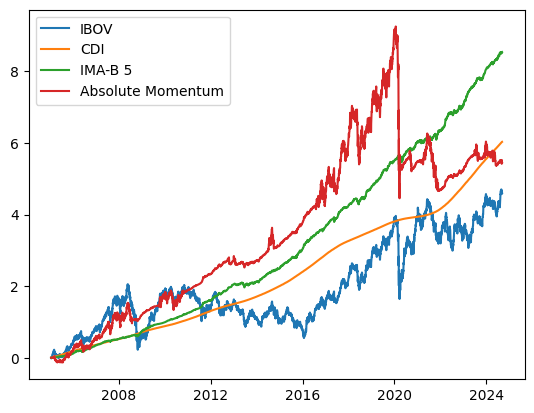

In [90]:
plt.plot(absolute_momentum_eval)
plt.legend(absolute_momentum_eval.columns)
plt.show()

In [91]:
export_absolute_model = pd.DataFrame({'Daily Var': absolute_momentum['Absolute Momentum'], 'Return': absolute_momentum_eval['Absolute Momentum']})

export_absolute_model.to_csv('data/export_absolute_model.csv')